# Machine Learning Essentials SS25 - Exercise Sheet 1

## Proposed Solutions

## Exercise 1 - Linear Decision Boundaries

### Task 1

The decision boundary is defined by the points where the classifier output is zero, i.e.,
$$
\mathbf{w}^\top \mathbf{x} + b = 0.
$$
Given
$$
\mathbf{w} = \begin{bmatrix}1 \ -2 \ 3\end{bmatrix}^\top \quad \text{and} \quad b = -1,
$$
the equation becomes
$$
1\cdot x_1 - 2\cdot x_2 + 3\cdot x_3 - 1 = 0.
$$
This is a linear equation in 3 variables $x_1$, $x_2$, and $x_3$, so the decision boundary is a hyperplane in 3D.

### Task 2

The normal vector to the decision boundary is the weight vector:
$$
\mathbf{n} = \mathbf{w} = \begin{bmatrix}1 \ -2 \ 3\end{bmatrix}^\top.
$$
Since $\nabla_x(\mathbf{w}^\top \mathbf{x} + b) = \mathbf{w}$, this vector is perpendicular to the hyperplane and indicates its orientation, i.e. points in the direction of greatest increase of the function $\mathbf{w}^\top \mathbf{x} + b.$

### Task 3

#### (a)
The signed distance from a point $\mathbf{x}$ to the decision boundary is given by:
$$
d(\mathbf{x}) = \frac{\mathbf{w}^\top \mathbf{x} + b}{||\mathbf{w}||}.
$$
For the signed distance from $\mathbf{x} = [1,\, 1,\, 1]^\top$, we have
$$
\mathbf{w}^\top \mathbf{x} = 2 \implies \mathbf{w}^\top \mathbf{x} + b = 1.
$$
Computing the norm of $\mathbf{w}$ gives
$$
||\mathbf{w}|| = \sqrt{1^2 + (-2)^2 + 3^2} = \sqrt{1 + 4 + 9} = \sqrt{14}.
$$
Thus the signed distance is
$$
d(\mathbf{x}) = \frac{1}{\sqrt{14}}.
$$

#### (b) 
The sign of $d$ decides which class is predicted: <br>
- A positive $d$ means the point is on the side of the hyperplane's orientation (the positive class).
- A negative $d$ means it lies on the opposite side.

#### (c)
The magnitude $|d(\mathbf{x})|$ indicates how far the point is from the decision boundary. A larger magnitude thus means that the point is far away from the boundary, which corresponds to a more confident prediction. (This is called the margin, if $\mathbf{x}$ is a support vector in an SVM)

#### (d)

Our task is to project $\mathbf{x}$ onto the decision boundary along its "normal" direction  $\frac{\mathbf{w}}{||\mathbf{w}||}$ (since $\mathbf{n} = \mathbf{w}$). This projection can be written as 
$$
\mathbf{x}_{\text{proj}} = \mathbf{x} - \lambda \frac{\mathbf{w}}{||\mathbf{w}||}
$$
for some scalar $\lambda$. This scalar we can identify by $\lambda = d(\mathbf{x})$, as it's exactly the orthogonal distance from $\mathbf{x}$ to the hyperplane. Thus
$$
\mathbf{x}_{\text{proj}} = \mathbf{x} - d(\mathbf{x}) \cdot \frac{\mathbf{w}}{||\mathbf{w}||}.
$$
Plugging in the values gives
$$
\mathbf{x}_{\text{proj}} = \begin{bmatrix} 1 \ 1 \ 1 \end{bmatrix}^\top - \frac{1}{\sqrt{14}} \cdot \begin{bmatrix} \frac{1}{\sqrt{14}} \ \frac{-2}{\sqrt{14}} \ \frac{3}{\sqrt{14}} \end{bmatrix}^\top = \begin{bmatrix} \frac{13}{14} \ \frac{16}{14} \ \frac{11}{14} \end{bmatrix}^\top.
$$

#### (e) 
The length of the orthogonal projection of a point to the decision boundary is called the (geometrical) <b>margin</b> for this particular point. In SVMs, the margin refers to the distance between support vectors and the decision boundary, and the optimal decision boundary is given by the <b>maximal margin classifier</b>, thus the position and orientation of the optimal decision boundary is determined by the support vectors. In essence, you could compute the orthogonal projection for every point in the training data, and the ones with the smallest distance are your support vectors (they are called that way because they "support" the margin). This way the process of computing this orthogonal projection is directly related to computing the margin and identifying the support vectors. Note however that in contrast to the Perceptron, the SVM does not iteratively go through all the datapoints, since it's a global optimization method.

## Exercise 2 - The Perceptron Algorithm

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import os
os.environ["OMP_NUM_THREADS"] = "10"

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


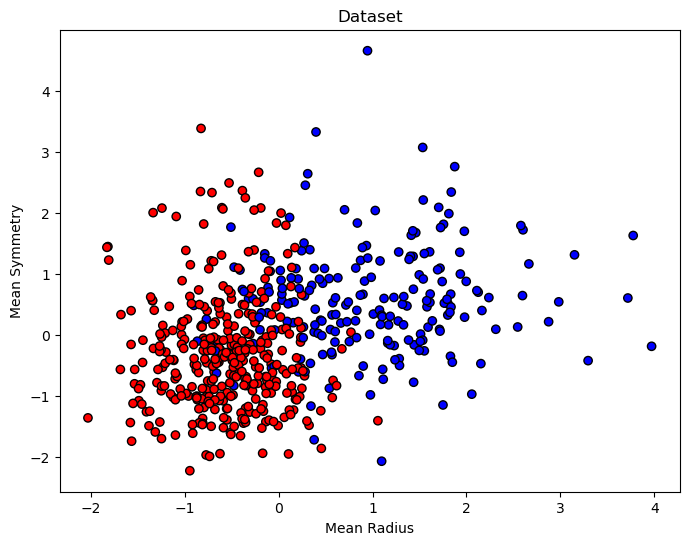

In [8]:
# ===============================
# 1. Load & Visualize the Dataset
# ===============================

# Load dataset
bc_data = load_breast_cancer()
# Print feature names
print(bc_data.feature_names)

# Select features & corresponding labels
X = bc_data.data[:, np.isin(bc_data.feature_names, ['mean radius', 'mean texture'])] # Select 'mean radius' and 'mean texture' features
y = bc_data.target  # Binary labels: 0 (benign), 1 (malignant)

# Convert labels from {0,1} to {-1,1} to match Perceptron convention from sheet
y = 2 * (y - 0.5) 

# Standardize the data to zero mean and unit variance
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
'''
This is useful for making sure the features are on the same scale. Thus, when training the Perceptron, the effect of each feature on the decision boundary will be proportional to its weight, which ultimately makes the training process faster and more stable (that's not just useful for the Perceptron, but for many learning algorithms).
'''

# Visualize dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
plt.title("Dataset")
plt.xlabel("Mean Radius")
plt.ylabel("Mean Symmetry")
plt.show()

In [9]:
# ========================
# 2. Implement the Perceptron's training algorithm
# ========================

class Perceptron:
    def __init__(self, learning_rate=0.1, num_epochs=10):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.w = None  # Weights
        self.b = None # Bias
        self.history = [] # Store parameters for decision boundary @ each update for visualization
    
    def train(self, X, y):
        """Train the perceptron using the online Perceptron algorithm."""
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features) # Initialize weights & bias to zeros
        self.b = 0

        # Train for num_epochs iterations
        for _ in range(self.num_epochs):
            for i in range(n_samples):
                X_i = X[i]
                # Update rule, as given on the sheet
                if y[i] != self.predict(X_i):
                    self.w += self.learning_rate * y[i] * X_i
                    self.b += self.learning_rate * y[i]
                    self.history.append((self.w,self.b)) # Save state for visualization 

    def predict(self, X):
        """Predict the label of a sample."""
        return np.sign(np.dot(X, self.w) + self.b)

In [10]:
# ========================
# 3. Train the Perceptron & Evaluate Performance
# ========================

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
perceptron = Perceptron(learning_rate=0.1, num_epochs=10) # Initialize Perceptron, use 10 epochs
perceptron.train(X_train,y_train)

# Predict and compute accuracy
"""
The accuracy classification metric is defined as the proportion of correctly classified samples vs. the total number of samples: Accuracy = (TP+TN)/(TP+TN+FP+FN).
"""

train_preds = perceptron.predict(X_train)
test_preds = perceptron.predict(X_test)

train_acc = np.mean(train_preds == y_train)
test_acc = np.mean(test_preds == y_test)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Training Accuracy: 0.901
Test Accuracy: 0.851


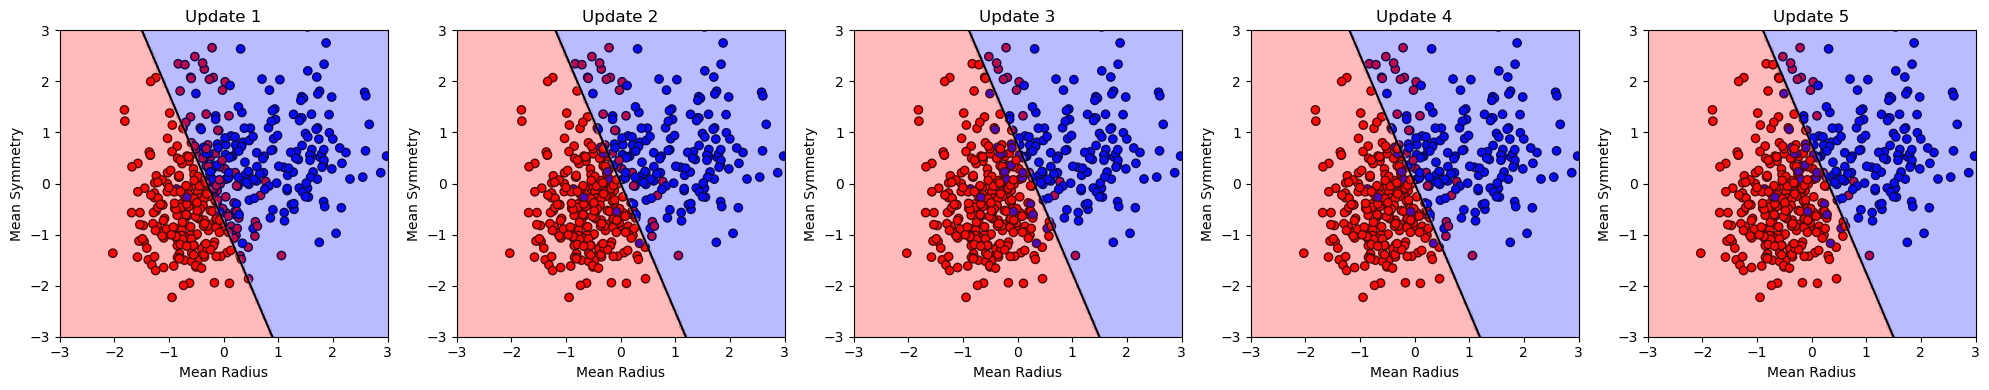

In [11]:
# ========================
# 4. Plot decision boundary evolution
# ========================

# Visualize the first 5 consecutive decision boundaries for data
decision_boundaries = perceptron.history[:5] # Get the parameters of the first 5 decision boundaries used during training

#Plot decision boundaries for iterations 1-5
plt.figure(figsize=(20, 4))
for i, (w, b) in enumerate(decision_boundaries):
    plt.subplot(1, len(decision_boundaries), i + 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', edgecolor='k')
    plt.title(f"Update {i+1}")
    plt.xlabel("Mean Radius")
    plt.ylabel("Mean Symmetry")
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)

    # to plot the decision boundary itself , we need to find the equation of the line w1*x1 + w2*x2 + b = 0
    # --> x2 = (-w1*x1 - b) / w2
    x_vals = np.array([-3, 3])
    y_vals = (-w[0] * x_vals - b) / w[1]
    plt.plot(x_vals, y_vals, color='k')

    #contour plot for visualization of classification regions
    xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
    Z = np.sign(np.dot(np.vstack([xx.ravel(), yy.ravel()]).T, w) + b)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')

plt.tight_layout()
plt.show()

### 5. Convergence of the algorithm
After inspecting the updates for 5 iterations, one might already guess that the model will not converge, as the decision boundaries do not seem to monotically improve. In fact, the model will not converge at all. This is because the "mistake-driven" learning rule of the Perceptron will cause the updates to continue indefinetly if the data is not linearly separable. Which is also the reason we need to specify a maximum number of epochs. 

(If the data is linearly separable however, the Perceptron Convergence Theorem guarantees that the perceptron will converge in a finite number of updates.)

Mean Test Accuracy: 0.846
Standard Deviation of Test Accuracy: 0.049


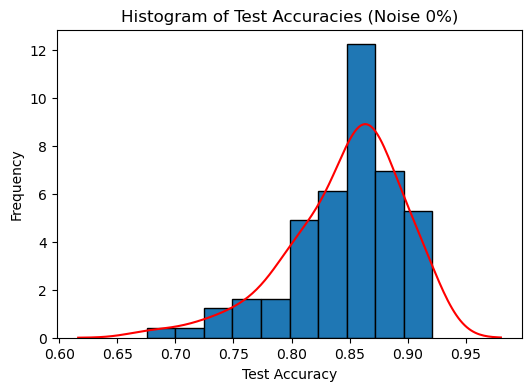

In [12]:
# ========================
# 6. Evaluate Performance Over Multiple Runs
# ========================

import seaborn as sns # Seaborn is a library based on matplotlib that provides tools for statistical data visualization. You can install it via "pip install seaborn".

def run_experiment(noise_level=0, n_runs=100, epochs=10):
    """Run one experiment with or without noise, train, evaluate and return test accuracies."""
    test_accuracies = []
    for run in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        # Noise: randomly flip p% of the training labels
        if noise_level > 0:
            n_noise = int(noise_level/100 * len(y_train))
            noise_indices = np.random.choice(len(y_train), n_noise, replace=False)
            y_train[noise_indices] = -y_train[noise_indices]
        # Train Perceptron 
        perceptron = Perceptron(learning_rate=0.1, num_epochs=epochs)
        perceptron.train(X_train, y_train)
        # Evaluate on the test set
        test_preds = perceptron.predict(X_test)
        accuracy = np.mean(test_preds == y_test)
        test_accuracies.append(accuracy)
    return np.array(test_accuracies)

# Run experiment without noise
test_acc = run_experiment(noise_level=0, n_runs=100, epochs=10)
mean_acc = np.mean(test_acc)
std_acc = np.std(test_acc)
print(f"Mean Test Accuracy: {mean_acc:.3f}")
print(f"Standard Deviation of Test Accuracy: {std_acc:.3f}")

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(test_acc, bins=10, edgecolor='black',density=True)
sns.kdeplot(test_acc, color='r')
plt.title("Histogram of Test Accuracies (Noise 0%)")
plt.xlabel("Test Accuracy")
plt.ylabel("Frequency")
plt.show()

### (a)
The shape of the histogram provides an estimate of the generalization error of the model. The peak approximates the true test accuracy and the spread gives an idea about the uncertainty of the estimate. Even though the Perceptron is a deterministic algorithm, the randomness in the training data (due to random train-test splits) leads to different test accuracies. (Another source of randomness could be given by e.g. initializing the parameters by sampling them from some probability distribution)

### (c)

For larger and larger sample sizes, the histogram approximates a normal distribution. 

The reason for this is the <b>Central Limit Theorem</b>, which states that for a series of $n \in \mathbb{N}$ i.i.d. random variables $X_i$, with finite variance $\sigma^2$, the sample mean $\bar{X}_n$ satisfies:

$$
\bar{X}_n \xrightarrow{d} \mathcal{N}(\mu, \sigma^2/n), \quad \text{for large } n.
$$

In our context, the mean $\mu$ of this distribution represents the expected generalization performance (i.e. the classification accuracy on new, unseen data), while $\sigma$ reflects the variability in performance due to differences in training data splits. The i.i.d. assumption is justified because our accuracies are independent samples from the distribution of the true test error.

From a <b>statistical learning perspective</b>, this connects to the idea of <b> empirical risk minimization (ERM)</b>. We train models based on a finite training set where we aim to minimize the <b>empirical risk</b> - the average error over the training data. However, what we ultimately care about is the <b>true risk</b>, which is the expected error on new, unseen data. The test accuracy serves as an empirical estimate of the model's true generalization ability, but it fluctuates due to differences in the training data. The CLT tells us that these fluctuations are approximately normal, allowing us to make statistical inferences about the model's generalization performance.

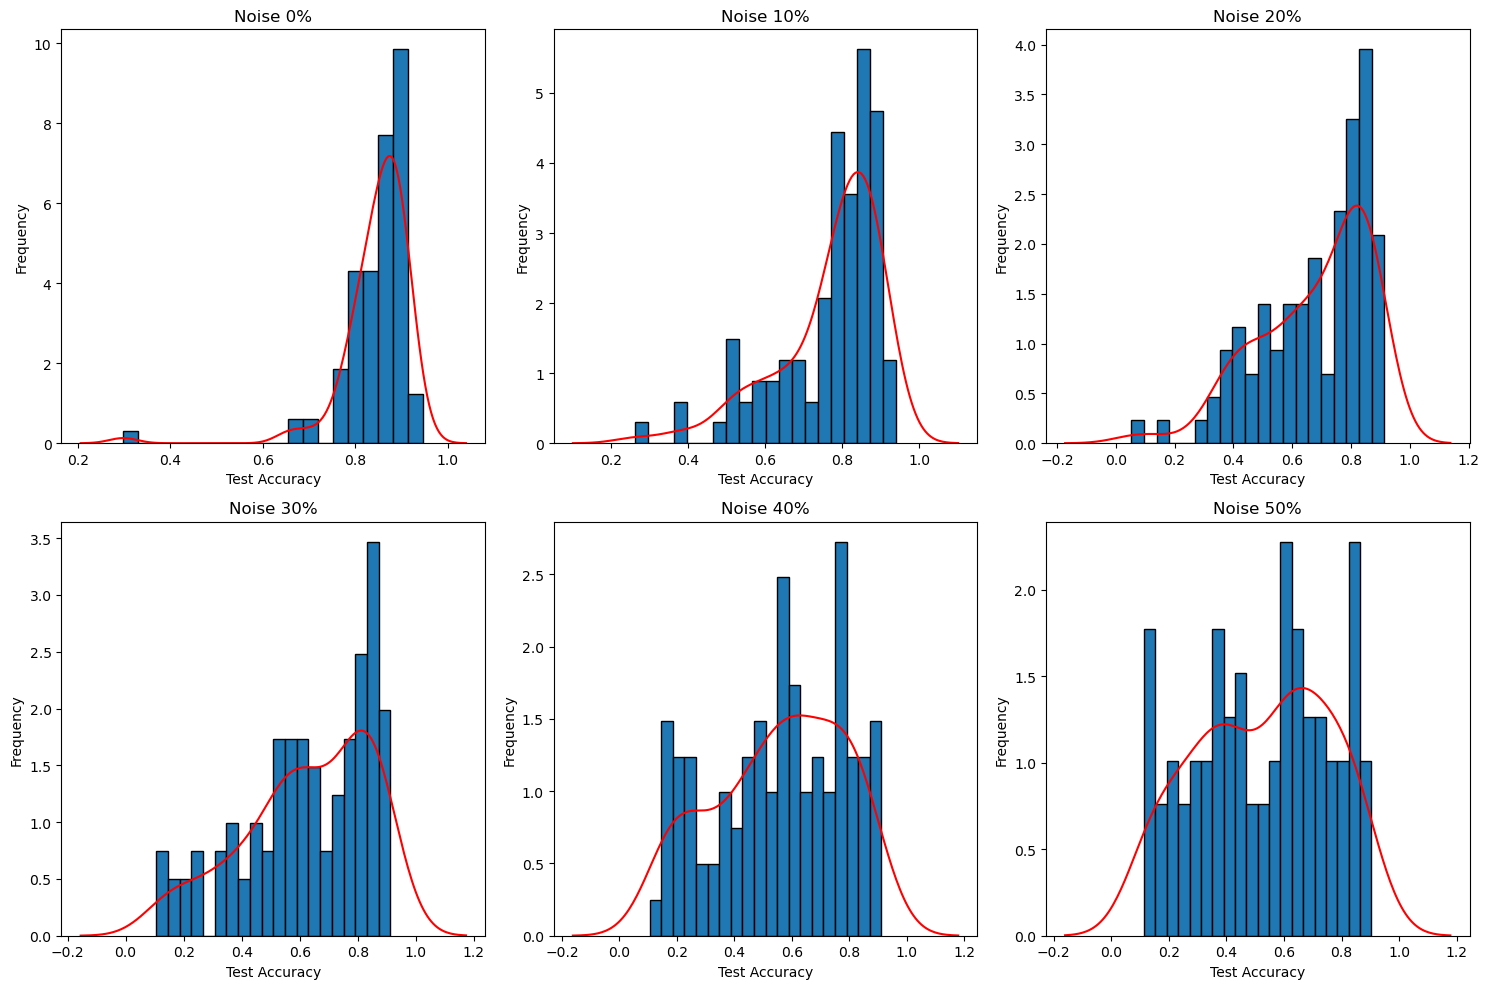

In [13]:
p_values = [0, 10, 20, 30, 40, 50] # % of flipped training labels
test_accuracies = []
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, noise in enumerate(p_values):
    accuracies = run_experiment(noise_level=noise, n_runs=100, epochs=10)
    axes[idx].hist(accuracies, bins=20, edgecolor='black', density=True)
    sns.kdeplot(accuracies, color='r', ax=axes[idx]) # add kernel density estimation plot
    axes[idx].set_title(f"Noise {noise}%")
    axes[idx].set_xlabel("Test Accuracy")
    axes[idx].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

The histograms show the distribution of test accuracies over 100 runs for different levels of label noise. The modes of the distributions shift towards lower accuracy as the level of noise increases, while the uncertainty increases. For 50% label noise, the distribution is roughly centered around 0.5 test accuracy, which corresponds to pure guessing in a binary classification task.

## Exercise 3: SVM

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_blobs
from cvxopt import matrix, solvers # Install cvxopt via "pip install cvxopt"

In [10]:
# ========================
# 1. Complete SVM implementation
# ========================

class DualSVM:
    def __init__(self, C=1.0, kernel="linear", gamma=1.0):
        self.C = C # Regularization constant
        self.kernel = kernel # Kernel type: "linear" or "rbf"
        self.gamma = gamma # Kernel parameter ("bandwith")
        self.alpha = None # Lagrange multipliers
        self.sv_X = None # Support vectors
        self.sv_y = None # Support vector labels
        self.w = None # Weights
        self.b = None # Bias

    def linear_kernel(self, X1, X2):
        # Compute linear kernel: K(x_i, x_j) = x_i^T x_j
        return np.dot(X1, X2.T)

    def rbf_kernel(self, X1, X2):
        # Compute RBF kernel: K(x_i, x_j) = exp(-gamma * ||x_i - x_j||^2)
        return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2, axis=2) ** 2)

    def compute_kernel(self, X1, X2):
        if self.kernel == "linear":
            return self.linear_kernel(X1, X2)
        elif self.kernel == "rbf":
            return self.rbf_kernel(X1, X2)
        else:
            raise ValueError("Unknown kernel type.")

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Compute kernel matrix K: K[i,j] = K(x_i, x_j)
        K = self.compute_kernel(X, X)

        """
        The dual objective is:
            max  sum_i alpha_i - 1/2 sum_i sum_j alpha_i alpha_j y_i y_j K(x_i, x_j)
        subject to:
            sum_i alpha_i y_i = 0  and  0 <= alpha_i <= C for all i.
        In QP formulation:
            P = (y_i y_j K(x_i,x_j))_{i,j},   q = -1 (vector),
            A = y^T, b = 0, and G, h implement 0 <= alpha_i <= C.
        """

        # Use the matrix function of cvxopt to define the QP parameters
        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        A = matrix(y, (1, n_samples),"d") # Use "d" flag to make sure that the matrix is in double precision format (labels are integers)
        b = matrix(0.0)
        
        # G and h implement the inequality constraint:
        #   -alpha <= 0  and  alpha <= C
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), self.C * np.ones(n_samples))))

        # Solve the quadratic programming problem using cvxopt
        solvers.options["show_progress"] = False
        solution = solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(solution["x"]) # Get optimal alphas

        # Get support vectors (i.e. data points with non-zero lagrange multipliers, that are on the margin)
        sv = alphas > 1e-5 # alpha > 1e-5 to account for numerical errors
        self.alpha = alphas[sv]
        self.sv_X = X[sv]
        self.sv_y = y[sv]

        # The bias corresponds to the average error over all support vectors:
        self.b = np.mean(self.sv_y - np.sum(self.alpha * self.sv_y * K[sv][:, sv], axis=1))

    def predict(self, X):
        # Predict by computing the decision function: f(x) = sum(alpha_i y_i K(x,x_i)) + b
        K = self.compute_kernel(X, self.sv_X)
        predictions = np.sum(self.alpha * self.sv_y * K, axis=1) + self.b
        return np.sign(predictions)

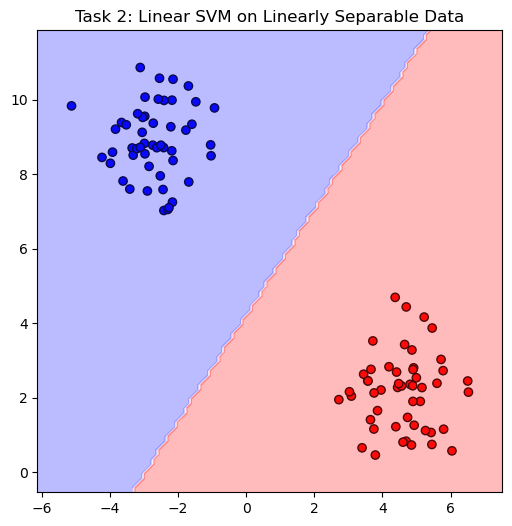

In [16]:
# ========================
# 2. Apply linear SVM on blobs
# ========================

# Define function for visualizing decision boundaries
def plot_decision_boundary(X, y, model, title="SVM Decision Boundary"):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", edgecolors="k")
    
    # Create grid over feature space for contour plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="bwr")
    plt.title(title)
    plt.show()

# Generate blobs dataset
X_linear, y_linear = make_blobs(n_samples=100, centers=2, n_features=2, random_state=42)
# Convert labels from {0,1} to {-1,1}
y_linear = 2 * (y_linear - 0.5)

svm = DualSVM(C=1.0, kernel="linear")
svm.fit(X_linear, y_linear)

plot_decision_boundary(X_linear, y_linear, svm, "Task 2: Linear SVM on Linearly Separable Data")

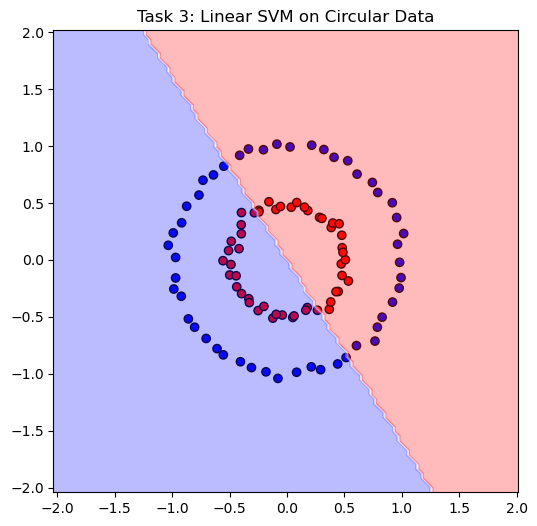

In [21]:
# ===========================
# 3. Apply linear SVM on circles
# ===========================
X_circles, y_circles = make_circles(n_samples=100, noise=0.025, factor=0.5, random_state=42)
y_circles = 2 * (y_circles - 0.5)  # Convert labels from {0,1} to {-1,1}

# Train a linear SVM on the circles data (expected to perform poorly)
svm_circles = DualSVM(C=1, kernel="linear")
svm_circles.fit(X_circles, y_circles)
plot_decision_boundary(X_circles, y_circles, svm_circles, "Task 3: Linear SVM on Circular Data")

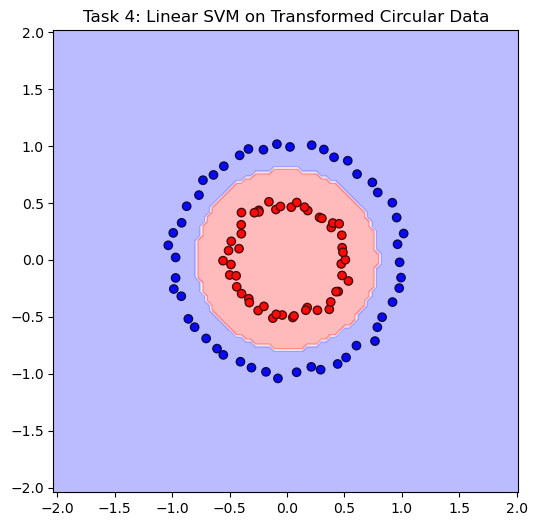

In [18]:
# ===========================
# 4. Feature transformation for linear separability
# ===========================
def transform_features(X):
    # Feature mapping: f(x) = [x1, x2, x1^2 + x2^2]
    return np.hstack([X, np.sum(X**2, axis=1)[:, np.newaxis]])

X_transformed = transform_features(X_circles)

# Train linear SVM on the transformed features
svm_transformed = DualSVM(C=1.0, kernel="linear")
svm_transformed.fit(X_transformed, y_circles)

def plot_decision_boundary_transformed(X, y, model, title="SVM Decision Boundary (Transformed)"):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", edgecolors="k")
    
    # Create a grid in the original 2D space
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Apply ransformation to the grid
    grid_transformed = transform_features(np.hstack([xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]]))
    Z = model.predict(grid_transformed)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="bwr")
    plt.title(title)
    plt.show()

plot_decision_boundary_transformed(X_circles, y_circles, svm_transformed, "Task 4: Linear SVM on Transformed Circular Data")


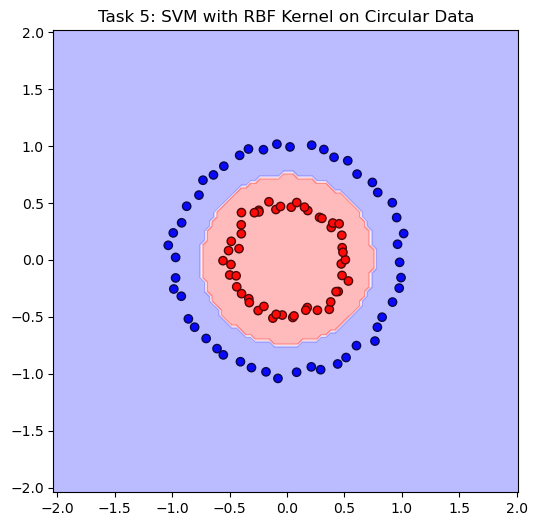

In [93]:

# ===========================
# 5. SVM with RBF Kernel on Circular Data
# ===========================
svm_rbf = DualSVM(C=1.0, kernel="rbf", gamma=1.0)
svm_rbf.fit(X_circles, y_circles)
plot_decision_boundary(X_circles, y_circles, svm_rbf, "Task 5: SVM with RBF Kernel on Circular Data")

### 6.

- In Task 3, the linear SVM is applied to circular data without any modification, so its linear decision boundary fails to capture the true structure of the data. In Task 4, by explicitly transforming the features via $f(\mathbf{x})$, we lift the data to a higher-dimensional space, where it becomes linearly separable. This results in a nonlinear boundary when projected back to the original space. <br><br>
- In Task 5, the use of an RBF kernel allows the SVM to implicitly work in a high-dimensional space. Its decision boundary is nonlinear without the need for an explicit feature mapping. <br><br>
- In summary, an explicit feature transformation requires manual design of the mapping. It is preferable when the transformation is low-dimensional so we can work directly with the transformed features, which might be beneficial for large datasets. In contrast, the kernel trick is preferable if the feature space should be very high-dimensional (or even infinite-dimensional), because it circumvents the need of explicitly computing the mapping. So in general, the kernel trick is more flexible if the underlying nonlinearities are not obvious.


### 7. 
The primal formulation (for a soft-margin SVM)
$$
\begin{aligned}
& \min_{\mathbf{w}} && \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^{n} \operatorname{ReLU}(1 - y_i (\mathbf{w}^\top \mathbf{x}_i + b)) \\
\end{aligned}
$$
directly optimizes over the weight vector $\mathbf{w} \in \mathbb{R}^d$, making it efficient when the feature dimension $d$ is small. In contrast, the dual formulation introduces one variable $\alpha_i$ per training sample and (crucially) <b> allows the use of kernel functions </b>, because it is expressed in terms of dot products $\mathbf{x}_i^\top \mathbf{x}_j$, which can be replaced by $K(\mathbf{x}_i, \mathbf{x}_j)$ (the "kernel trick"). Thus, the dual formulation is preferable when the number of features is large or if nonlinear (implicit) feature mappings are required.